In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from dgp import ExperimentImpact, ratio_data_dgp
from ate import RatioATE

# Simulations with DGP
Following analysis based on: https://bytepawn.com/reducing-variance-in-ab-testing-with-cuped.html

In [90]:
# Setup dgp and experiment
dgp = ratio_data_dgp(
    poisson_lams=np.array([2,5,30]),
    poisson_multi_pre=5,
    poisson_multi_exp=2,
    mean_prob_success = np.array([0.3, 0.5, 0.8]),
    std_prob_success=np.array([0.05,0.05,0.05])
    )
experiment_impact = ExperimentImpact(
    perc_prob_success_change=2, 
    width_perc_prob_change=0
    )

In [91]:
num_sim = 10000
traditional_lifts, adjusted_lifts = [], []
traditional_lifts_perc, adjusted_lifts_perc = [], []
traditional_pvalues, adjusted_pvalues = [], []
rho_sq_list = []

for _ in range(num_sim):
    gen_df_expt = dgp.dgp(experiment_impact=experiment_impact)
    
    control_group = gen_df_expt[gen_df_expt.treatment==0]
    treatment_group = gen_df_expt[gen_df_expt.treatment==1]

    cuped_test = RatioATE(
        control_group=control_group,
        treatment_group=treatment_group,
        numer='Y',
        denom='N',
        suffix_expt='_exp',
        suffix_pre=''
    )
    cuped_test.ratio_ate()
    cuped_test.ratio_ate_cuped()
    traditional_lifts += [cuped_test.ate]
    traditional_pvalues += [cuped_test.pval]
    adjusted_lifts += [cuped_test.ate_cuped]
    adjusted_pvalues += [cuped_test.pval_cuped]
    traditional_lifts_perc += [cuped_test.ate*100/(cuped_test.Y_bar_c/cuped_test.N_bar_c)]
    adjusted_lifts_perc += [cuped_test.ate_cuped*100/(cuped_test.Y_bar_c/cuped_test.N_bar_c)]
    rho_sq_list += [cuped_test.rho_sq]


In [92]:
print('Traditional    A/B testing, mean lift = %.5f, variance of lift = %.5f' % (np.mean(traditional_lifts), np.cov(traditional_lifts)))
print('CUPED adjusted A/B testing, mean lift = %.5f, variance of lift = %.5f' % (np.mean(adjusted_lifts), np.cov(adjusted_lifts)))

print('Traditional    A/B testing, mean perc lift = %.5f' % (np.mean(traditional_lifts_perc)))
print('CUPED adjusted A/B testing, mean perc lift = %.5f' % (np.mean(adjusted_lifts_perc)))

print('CUPED lift variance / tradititional lift variance = %.5f' % (np.cov(adjusted_lifts)/np.cov(traditional_lifts)))
print('(mean) Expected ratio of lift variance = %.5f' % (1-np.mean(rho_sq_list)))

Traditional    A/B testing, mean lift = 0.01289, variance of lift = 0.00030
CUPED adjusted A/B testing, mean lift = 0.01297, variance of lift = 0.00008
Traditional    A/B testing, mean perc lift = 2.00396
CUPED adjusted A/B testing, mean perc lift = 1.99073
CUPED lift variance / tradititional lift variance = 0.26363
(mean) Expected ratio of lift variance = 0.26483


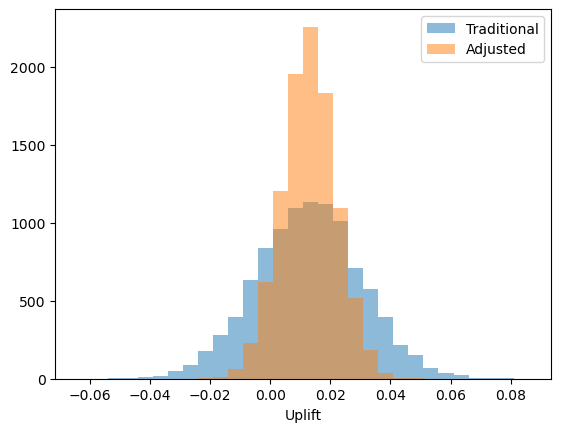

In [93]:
step=0.005
bins = np.arange(
    min(traditional_lifts+adjusted_lifts)-2*step, 
    max(traditional_lifts+adjusted_lifts)+2*step, 
    step=step)
plt.hist(traditional_lifts, alpha=0.5, bins=bins)
plt.hist(adjusted_lifts, alpha=0.5, bins=bins)
plt.xlabel('Uplift')
plt.legend(['Traditional', 'Adjusted'])
plt.show()

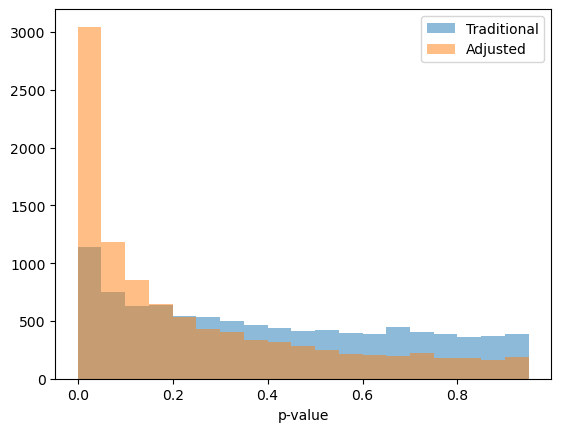

In [94]:
step=0.05
bins = np.arange(
    0, 
    1, 
    step=step)
plt.hist(traditional_pvalues, alpha=0.5, bins=bins)
plt.hist(adjusted_pvalues, alpha=0.5, bins=bins)
plt.xlabel('p-value')
plt.legend(['Traditional', 'Adjusted'])
plt.show()

## Counter-intuitive results

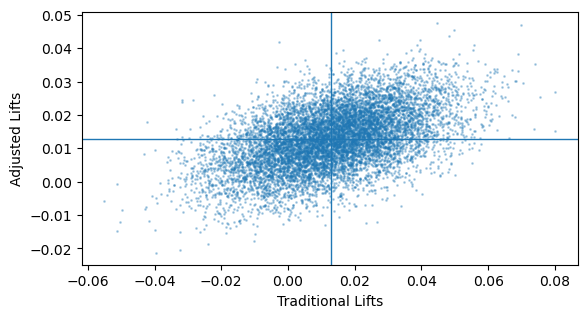

In [84]:
plt.scatter(x=traditional_lifts, y=adjusted_lifts, s=1, alpha=0.3)
plt.axvline(x=np.mean(traditional_lifts), lw=1)
plt.axhline(y=np.mean(adjusted_lifts), lw=1)
plt.xlabel('Traditional Lifts')
plt.ylabel('Adjusted Lifts')
plt.axis('scaled')
plt.show()

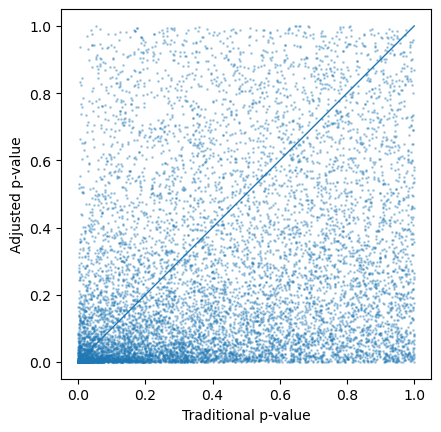

In [85]:
plt.scatter(x=traditional_pvalues, y=adjusted_pvalues, s=1, alpha=0.3)
plt.plot([0,1],[0,1], lw=1)
plt.xlabel('Traditional p-value')
plt.ylabel('Adjusted p-value')
plt.axis('scaled')
plt.show()

# Impact of past information

In [20]:
def cuped_simulations(dgp, experiment_impact, num_sim=10000):
    traditional_lifts, adjusted_lifts = [], []
    traditional_pvalues, adjusted_pvalues = [], []
    rho_sq_list = []

    for _ in range(num_sim):
        gen_df_expt = dgp.dgp(experiment_impact=experiment_impact)
        
        control_group = gen_df_expt[gen_df_expt.treatment==0]
        treatment_group = gen_df_expt[gen_df_expt.treatment==1]

        cuped_test = RatioATE(
            control_group=control_group,
            treatment_group=treatment_group,
            numer='Y',
            denom='N',
            suffix_expt='_exp',
            suffix_pre=''
        )
        cuped_test.ratio_ate()
        cuped_test.ratio_ate_cuped()
        traditional_lifts += [cuped_test.ate]
        traditional_pvalues += [cuped_test.pval]
        adjusted_lifts += [cuped_test.ate_cuped]
        adjusted_pvalues += [cuped_test.pval_cuped]
        rho_sq_list += [cuped_test.rho_sq]
    return (
        np.mean(traditional_lifts),
        np.mean(adjusted_lifts),
        np.cov(adjusted_lifts)/np.cov(traditional_lifts)
    )

### Length of pre-experimental data

In [103]:
past_data_length_range = np.concatenate([np.arange(1,10,0.5),np.arange(10,50,5), np.arange(50,100,10), np.arange(100,600,100)])
traditional_lifts, adjusted_lifts = [], []
variance_ratio = []

experiment_impact = ExperimentImpact(
    perc_prob_success_change=2, 
    width_perc_prob_change=0
    )

for i in past_data_length_range:
    # Setup dgp and experiment
    dgp = ratio_data_dgp(
        poisson_multi_pre=i,
        poisson_multi_exp=2,
        )
    sim_result = cuped_simulations(dgp, experiment_impact)
    traditional_lifts += [sim_result[0]]
    adjusted_lifts += [sim_result[1]]
    variance_ratio += [sim_result[2]]

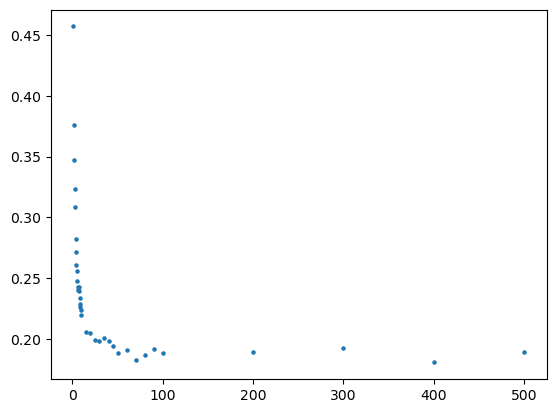

In [110]:
plt.scatter(past_data_length_range, variance_ratio, s=5)
plt.xlabel('Past data length (poisson lambda multiplier)')
plt.ylabel('Adjusted covariance / Traditional covariance')
plt.show()
plt.show()

### Probability of missing data

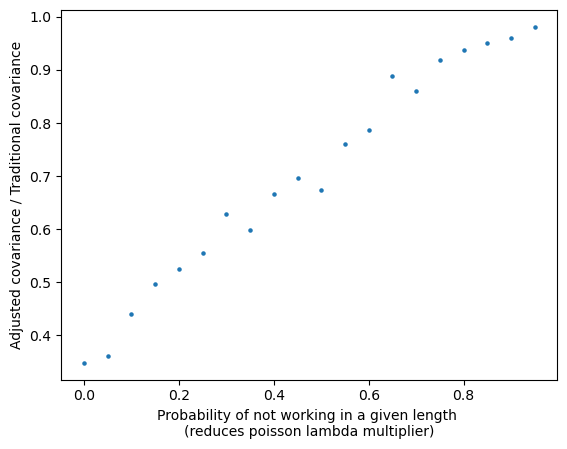

In [33]:
gen_df_expt = dgp.dgp(experiment_impact=experiment_impact)

prob_missing_range = np.arange(0,1,0.05)
traditional_lifts, adjusted_lifts = [], []
variance_ratio = []

experiment_impact = ExperimentImpact(
    perc_prob_success_change=2, 
    width_perc_prob_change=0
    )

for i in prob_missing_range:
    # Setup dgp and experiment
    dgp = ratio_data_dgp(
        poisson_multi_pre=2,
        poisson_multi_exp=2,
        prob_missing=i
        )
    sim_result = cuped_simulations(dgp, experiment_impact, num_sim=1000)
    traditional_lifts += [sim_result[0]]
    adjusted_lifts += [sim_result[1]]
    variance_ratio += [sim_result[2]]

plt.scatter(prob_missing_range, variance_ratio, s=5)
plt.xlabel('Probability of not working in a given length \n(reduces poisson lambda multiplier)')
plt.ylabel('Adjusted covariance / Traditional covariance')
plt.show()

In [40]:
dgp = ratio_data_dgp(
        poisson_multi_pre=2,
        poisson_multi_exp=2,
        prob_missing=0.2
        )
gen_df_expt = dgp.dgp(experiment_impact=experiment_impact)

control_group = gen_df_expt[gen_df_expt.treatment==0]
treatment_group = gen_df_expt[gen_df_expt.treatment==1]

cuped_test = RatioATE(
    control_group=control_group,
    treatment_group=treatment_group,
    numer='Y',
    denom='N',
    suffix_expt='_exp',
    suffix_pre=''
)
# cuped_test.ratio_ate()
# cuped_test.ratio_ate_cuped()
# traditional_lifts += [cuped_test.ate]
# traditional_pvalues += [cuped_test.pval]
# adjusted_lifts += [cuped_test.ate_cuped]
# adjusted_pvalues += [cuped_test.pval_cuped]
# rho_sq_list += [cuped_test.rho_sq]

# Naive vs. Normalized vs. What we do!

In [31]:
# Setup dgp and experiment
dgp = ratio_data_dgp(
    poisson_lams=np.array([2,5,30]),
    poisson_multi_pre=5,
    poisson_multi_exp=2,
    mean_prob_success = np.array([0.3, 0.5, 0.8])
    )
experiment_impact = ExperimentImpact(
    perc_prob_success_change=1, 
    width_perc_prob_change=0
    )

In [32]:
num_sim = 10000
naive_lifts, normalized_lifts = [], []
naive_pvalues, normalized_pvalues, weird_pvalues = [], [], []

for _ in range(num_sim):
    gen_df_expt = dgp.dgp(experiment_impact=experiment_impact)
    
    control_group = gen_df_expt[gen_df_expt.treatment==0]
    treatment_group = gen_df_expt[gen_df_expt.treatment==1]

    cuped_test = RatioATE(
        control_group=control_group,
        treatment_group=treatment_group,
        numer='Y',
        denom='N',
        suffix_expt='_exp',
        suffix_pre=''
    )
    
    # Naive (ratio of averages)
    cuped_test.ratio_ate()
    naive_lifts += [cuped_test.ate]
    naive_pvalues += [cuped_test.pval]
    
    # Normalized (average of ratios)
    normalized_t = cuped_test.Y_t/cuped_test.N_t
    normalized_c = cuped_test.Y_c/cuped_test.N_c
    normalized_ate = normalized_t.mean() - normalized_c.mean()
    normalized_lifts += [normalized_ate]
    normalized_pval = cuped_test.pooled_zscore(
        ate=normalized_ate, 
        var=[np.var(normalized_c), np.var(normalized_t)],
        n=[cuped_test.n_c, cuped_test.n_t]
        )[0]
    normalized_pvalues += [normalized_pval]

    # Weird (what we do: normalized ate; naive variance)
    weird_pval = cuped_test.pooled_zscore(
        ate=normalized_ate,
        var_pooled=cuped_test.var_pooled,
        n=[cuped_test.n_c, cuped_test.n_t]
        )[0]
    weird_pvalues += [weird_pval]

print('Naive ratio      mean lift = %.5f, mean pval = %.5f' % (np.mean(naive_lifts), np.cov(naive_pvalues)))
print('Normalized ratio mean lift = %.5f, mean pval = %.5f' % (np.mean(normalized_lifts), np.cov(normalized_pvalues)))
print('Weird ratio      mean lift = %.5f, mean pval = %.5f' % (np.mean(normalized_lifts), np.cov(weird_pvalues)))
    

Naive ratio      mean lift = 0.00630, mean pval = 0.08691
Normalized ratio mean lift = 0.00456, mean pval = 0.08486
Weird ratio      mean lift = 0.00456, mean pval = 0.08231


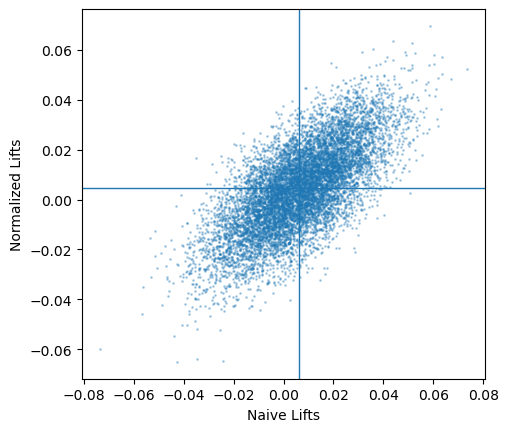

In [33]:
plt.scatter(x=naive_lifts, y=normalized_lifts, s=1, alpha=0.3)
plt.axvline(x=np.mean(naive_lifts), lw=1)
plt.axhline(y=np.mean(normalized_lifts), lw=1)
plt.xlabel('Naive Lifts')
plt.ylabel('Normalized Lifts')
plt.axis('scaled')
plt.show()

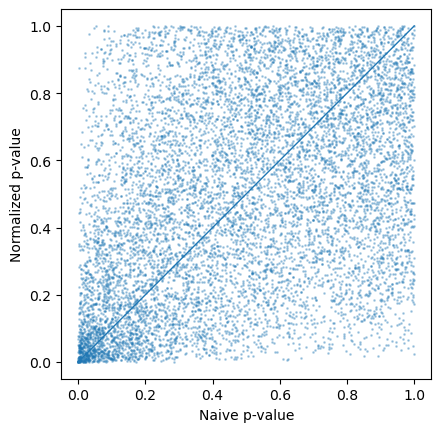

In [34]:
plt.scatter(x=naive_pvalues, y=normalized_pvalues, s=1, alpha=0.3)
plt.plot([0,1],[0,1], lw=1)
plt.xlabel('Naive p-value')
plt.ylabel('Normalized p-value')
plt.axis('scaled')
plt.show()

## Error analysis

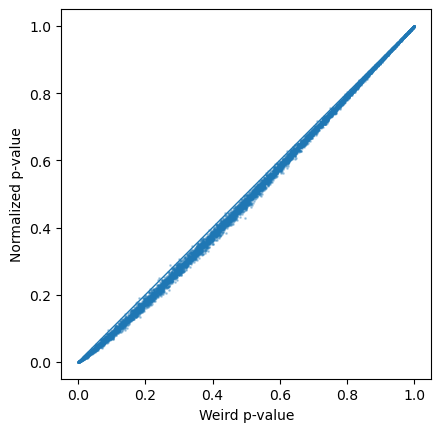

In [35]:
plt.scatter(x=weird_pvalues, y=normalized_pvalues, s=1, alpha=0.3)
plt.plot([0,1],[0,1], lw=1)
plt.xlabel('Weird p-value')
plt.ylabel('Normalized p-value')
plt.axis('scaled')
plt.show()

In [36]:
a = np.array(normalized_pvalues)
b = np.array(weird_pvalues)

# np.quantile(a[a<0.05]-b[a<0.05], 0.5)
len(b[(a<0.05) & (b>=0.05)])/sum(a<0.05)

0.2128

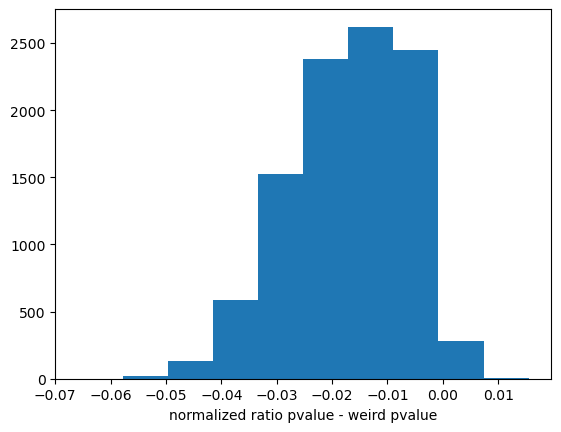

In [37]:
plt.hist(np.array(normalized_pvalues)-np.array(weird_pvalues))
plt.xlabel('normalized ratio pvalue - weird pvalue')
plt.show()

## Bootstrapping
As a check to see if our variance estimates (Delta method for naive, sample estimate for normalized) are correct

In [27]:
# Setup dgp and experiment
dgp = ratio_data_dgp(
    poisson_lams=np.array([2,5,30]),
    poisson_multi_pre=5,
    poisson_multi_exp=2,
    mean_prob_success = np.array([0.3, 0.5, 0.8])
    )
experiment_impact = ExperimentImpact(
    perc_prob_success_change=1, 
    width_perc_prob_change=0
    )

gen_df_expt = dgp.dgp(experiment_impact=experiment_impact)

In [28]:
# Our estimate
Y = gen_df_expt.Y
N = gen_df_expt.N
n = len(gen_df_expt)

normalized_ratio = (Y/N).mean()
normalized_ratio_var = np.var((Y/N), ddof=1)/n

naive_ratio = Y.mean()/N.mean()
beta = np.array([[1/N.mean(), -Y.mean()/(N.mean())**2]]).T
covar = np.cov(Y, N, ddof=1)
naive_ratio_var = ((beta.T @ covar @ beta))[0][0]/n

print(f'''
Mean and variance estimates of Normalized and Naive Ratios
for one instance of experiment (grouping control and 
treatement together) using the sample variance and the
Delta method, respectively:

Naive   mean: {naive_ratio}, 
Norm    mean: {normalized_ratio}

Naive / weird   var: {naive_ratio_var}, 
Norm            var: {normalized_ratio_var}
''')



Mean and variance estimates of Normalized and Naive Ratios
for one instance of experiment (grouping control and 
treatement together) using the sample variance and the
Delta method, respectively:

Naive   mean: 0.6537351880473983, 
Norm    mean: 0.4765908816226091

Naive / weird   var: 6.629759503103586e-05, 
Norm            var: 4.556114838429158e-05




In [29]:
# let's confirm with bootstrapping
n_boot = 10000
naive_ratio_bs, norm_ratio_bs = [], []
for _ in range(n_boot):
    bs_sample = gen_df_expt.sample(frac=1, replace=True)
    Y = bs_sample.Y
    N = bs_sample.N
    norm_ratio_bs += [(Y/N).mean()]
    naive_ratio_bs += [Y.mean()/N.mean()]

print(f'''
Bootstrap estimates of mean and variance estimates 
of Normalized and Naive Ratios for one instance of 
experiment (grouping control and treatement together):

Naive   mean: {np.mean(naive_ratio_bs)}, 
Norm    mean: {np.mean(norm_ratio_bs)}

Naive           var: {np.var(naive_ratio_bs)}, 
Norm            var: {np.var(norm_ratio_bs)}
''')


Bootstrap estimates of mean and variance estimates 
of Normalized and Naive Ratios for one instance of 
experiment (grouping control and treatement together):

Naive   mean: 0.6534214152777515, 
Norm    mean: 0.47654471249073277

Naive           var: 6.633800996085578e-05, 
Norm            var: 4.531618159218429e-05


